<a href="https://colab.research.google.com/github/VKarpick/powerplay/blob/main/powerplay_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hockey-rink

  Created wheel for hockey-rink: filename=hockey_rink-0.1.7-py3-none-any.whl size=34876 sha256=27e554be70e3639b2a5a497205c8c71f1139ad49fbb8cf51e34df7d1fc77c5aa
  Stored in directory: /root/.cache/pip/wheels/9b/9c/06/217d4c3a942284788e7fce440ef4e47a8d032cdceb372ff7ec
Successfully built hockey-rink


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hockey_rink import BDCRink, Crease, Net, Rink
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
from shapely.geometry.point import Point
from tqdm.auto import tqdm

In [3]:
pbp = pd.read_csv("https://raw.githubusercontent.com/the-bucketless/bdc/main/data/pxp_womens_oly_2022_v2.csv")
pp_info = pd.read_csv("https://raw.githubusercontent.com/the-bucketless/bdc/main/data/pp_info.csv")

# Data Prep

Some needed shapes to manipulate the data. Grabbing a couple features from the hockey_rink package to simplify creating their Polygons with shapely. All coordinates will be shifted to the right side of the rink (x-coordinates from 100 to 200) so that only one of each Polygon is needed.

In [4]:
def feature_to_polygon(feature):
    """ Convert a feature from the rink package to a shapley Polygon. """
    x, y = feature.get_polygon_xy()
    coords = zip(x + 100, y + 42.5)
    return Polygon(coords)


rink = Rink()

net = [feature for feature in rink._features if isinstance(feature, Net)][0]
NET_POLYGON = feature_to_polygon(net)

boards = rink._boards_constraint
BOARDS_POLYGON = feature_to_polygon(boards)
OZONE_POLYGON = Polygon(zip([125, 200, 200, 125], [0, 0, 85, 85]))

OZONE_BOARDS = BOARDS_POLYGON.intersection(OZONE_POLYGON)

ABOVE_GOAL_LINE = Polygon(zip([125, 189, 189, 125], [0, 0, 85, 85]))

# some coordinates much larger than the size of the rink used to bound
# voronoi shapes within the rink
BOUNDING_COORDS = [[-500, -500], [-500, 500], [500, -500], [500, 500]]

# where to place the goalie when no goalie is seen in frame
# well outside the rink to avoid affecting the voronoi shapes
# easier than including conditionals ensuring that the goalie is present
MISSING_GOALIE_COORD = (-100, -100)

# the radius of the circle around the goalie representing their outer bounds
GOALIE_RADIUS = 4

# the remainder of the goalie's bounds determined by the crease
crease_features = [feature for feature in rink._features if isinstance(feature, Crease)][:2]
crease_polygons = [feature_to_polygon(crease_feature) for crease_feature in crease_features]
CREASE_POLYGON = crease_polygons[0].union(crease_polygons[1])

# previously determined dangerous area of the ice
DANGER_ZONE = Polygon(zip([189, 174, 174, 189], [50.5, 50.5, 34.5, 34.5]))

## Play-by-play

In [5]:
def convert_game_time(period, seconds):
    """ Convert time from seconds remaining in period to seconds elapsed in game. """
    return 1200 * period - seconds


for prefix in ("start", "end"):
    pp_info[f"{prefix}_game_clock_seconds"] = convert_game_time(
        pp_info[f"{prefix}_period"], 
        pp_info[f"{prefix}_game_clock_seconds"]
    )

pbp["pbp_game_seconds"] = convert_game_time(pbp.period, pbp.clock_seconds)

# don't think there'll have need of the season
pbp = pbp.drop(columns=["season_year"])

# different naming in the tracking data and the play-by-play data, use tracking
team_names = {
    "Olympic (Women) - Canada": "Canada",
    "Olympic (Women) - Finland": "Finland",
    "Olympic (Women) - Olympic Athletes from Russia": "ROC",
    "Olympic (Women) - Switzerland": "Switzerland",
    "Olympic (Women) - United States": "USA",
}
for c in ("team_name", "opp_team_name"):
    pbp[c] = pbp[c].map(team_names)

# strength state for zone entries is that of the defending team
# reverse the order of words in the string to make it the attacking team's strength
is_zone_entry = pbp.event == "Zone Entry"
pbp.loc[is_zone_entry, "situation_type"] = pbp.situation_type.str.split().apply(lambda x: " ".join(x[::-1]))

Split passes with times into two events: one for the pass and one for when it's received.  
Successful passes are the only events with two frame IDs.

In [6]:
pbp["has_reception"] = ~pbp.frame_id_2.isna()

plays = pbp.loc[pbp.has_reception, :].copy()
plays["event"] = "Reception"
plays.frame_id_1 = plays.frame_id_2
plays["has_reception"] = False

pbp = (
    pbp
    .append(plays)
    .sort_index(kind="stable")
    .drop(columns="frame_id_2")
    .rename(columns={
        # since there are no longer two frame IDs to deal with, drop the suffix
        "frame_id_1": "frame_id", 
        # period also included in tracking data
        "period": "pbp_period", 
    })
    .reset_index(drop=True)
)

Using the event data to track which player has possession. Occasionally, players will lose possession without an event being recorded, but this should work well enough.

In [7]:
# events that denote possession subsequent to event
has_possession = (
    pbp.event.isin(["Puck Recovery", "Takeaway"])
    | ((pbp.event == "Zone Entry") & (pbp.event_type != "Dumped"))
)

pbp.loc[has_possession, "possession"] = pbp.player_name
pbp.possession = pbp.possession.fillna("loose")

# need the second player on pass receptions
# don't want second player on pass receptions until they've received the puck but
# plays exist that aren't in the tracking data which won't have receptions but still need to be tracked
plays = (
    (pbp.event == "Reception")
    | (~pbp.has_reception & (pbp.event == "Play") & (pbp.event_successful == "t"))
)
pbp.possession = pbp.possession.where(~plays, pbp.player_name_2)

# events that denote the player has the puck in a given frame but not after
pbp.loc[pbp.event.isin(["Shot", "Dump In/Out", "Play"]), "momentary_possession"] = pbp.player_name

## Roster

In [8]:
def get_roster(repo_game):
    roster = pd.read_csv(
        "https://github.com/the-bucketless/bdc/raw/main/data/"
        f"{repo_game}/"
        f"{repo_game}%20roster.csv"
    )
    
    # rename columns for consistency with tracking data
    roster = roster.rename(columns={"jn": "jersey_number", "team": "venue"})

    return roster

## Tracking Data

In [9]:
def get_tracking(repo_game, period, pp_number, away_team, home_team, roster=None):
    if roster is None:
        roster = get_roster(repo_game)

    tracking = pd.read_csv(
        "https://github.com/the-bucketless/bdc/raw/main/data/"
        f"{repo_game}/"
        f"{repo_game}%20P{period}%20PP{pp_number}.csv"
    )

    tracking["game_seconds"] = convert_game_time(tracking.period, tracking.game_seconds)
    tracking["venue"] = tracking.team_name.map({home_team: "home", away_team: "away"})

    tracking = tracking.merge(roster, on=["venue", "jersey_number"], how="left")

    tracking = tracking.rename(columns={"x_ft": "x", "y_ft": "y"})

    return tracking

## Play-by-Play from Individual Powerplay

In [10]:
def get_powerplay(pbp, tracking, game_date, away_team, home_team):
    # use pp_info to find the relevant section of the play-by-play
    selected_pp = pp_info[(pp_info.game_name == game_name) & (pp_info.penalty_number == pp_number)].iloc[0]
    selected_teams = [home_team, away_team]

    # dates are listed in different formats in the two files
    # convert from yyyy-mm-dd with leading zeros to d/m/yyyy without
    pbp_date = "/".join([str(int(x)) for x in game_date.split("-")[::-1]])

    powerplay = (
        pbp[
            (pbp.game_date == pbp_date)
            & (pbp.pbp_game_seconds >= selected_pp.start_game_clock_seconds)
            & (pbp.pbp_game_seconds <= selected_pp.end_game_clock_seconds)
            & (pbp.team_name.isin(selected_teams))
            & (pbp.opp_team_name.isin(selected_teams))
            # remove edge events outside the powerplay
            & pbp.situation_type.isin(["5 on 4", "4 on 5"])
            ]
        .copy()
    )

    # add video shot to play-by-play data to provide frame_id for events without
    powerplay = powerplay.merge(
        tracking[["frame_id", "video_shot", "game_seconds"]].drop_duplicates(), 
        on="frame_id", 
        how="left"
    )
    powerplay.video_shot = powerplay.video_shot.bfill()

    # for frames not in the tracking data, use the time from the play-by-play
    powerplay.game_seconds = powerplay.game_seconds.fillna(powerplay.pbp_game_seconds)

    # for events without frame_id in the pbp, use one less than the mininum of the subsequent video shot
    # ie) if the next frame_id found comes from video shot 2, find the smallest frame_id from
    # video shot 2 and use one less. This will place the frame_id between video shot 1 and video shot 2
    min_frames = (
        (
            tracking
            .groupby("video_shot")
            ["frame_id"]
            .min()
            - 1
            )
        .to_dict()
    )

    # use 1 less than the minimum frame_id of the video shot for events without frame_id
    powerplay.frame_id = powerplay.frame_id.fillna(powerplay.video_shot.map(min_frames))

    # track whether or not a player's first in-zone possession is off a zone entry
    powerplay["is_zone_entry"] = powerplay.event == "Zone Entry"

    # whether or not the puck is in the ozone of the team with the advantage
    is_pp = powerplay.situation_type == "5 on 4"
    powerplay.loc[is_pp & powerplay.is_zone_entry, "is_pp_ozone"] = True
    powerplay.loc[is_pp & (powerplay.x_coord > 124), "is_pp_ozone"] = True
    powerplay.loc[~is_pp & (powerplay.x_coord < 26), "is_pp_ozone"] = True
    powerplay.is_pp_ozone = powerplay.is_pp_ozone.fillna(False)

    return powerplay

## Possession Data

Combine tracking data with powerplay play-by-play to find the location of the player with possession.

In [11]:
def get_possession(tracking, powerplay):
    merge_columns = [
        "frame_id", "possession", "momentary_possession", "event", "is_zone_entry", "is_pp_ozone",
    ]
    
    possession = tracking.merge(
        powerplay[merge_columns], 
        on="frame_id", 
        how="outer", 
    )
    possession = possession.sort_values("frame_id", kind="stable")

    # zone entries will already have True values
    possession.is_zone_entry = possession.is_zone_entry.fillna(False)

    # ffill could potentially miss situations where player takes puck from inside zone to outside
    # no such issue was found when inspecting data
    possession.is_pp_ozone = possession.is_pp_ozone.ffill()

    # replace values where players only had possession for a single frame
    # these were previously ignored to avoid incorrectly ffilling them
    possession.possession = possession.possession.ffill()
    possession.possession = possession.momentary_possession.fillna(possession.possession)

    # how and when possession was acquired by the player; default is Retained
    is_acquired = possession.event.isin(["Puck Recovery", "Zone Entry", "Reception", "Takeaway"])
    possession.loc[is_acquired, "acquisition"] = possession.event
    possession.acquisition = possession.acquisition.fillna("Retained")

    # combine takeaways and puck recoveries into same category
    possession.acquisition = possession.acquisition.replace({"Takeaway": "Puck Recovery"})

    possession_columns = [
        "frame_id", "possession", "team_name", "x", "y", "acquisition", "is_zone_entry", "is_pp_ozone",
    ]
    possession = (
        possession
        # remove frames without tracking data
        .dropna(subset=["track_id"])

        # only keep the row of the player with possession to get their coordinates
        # also needs frames where the puck is loose
        .loc[
            possession.possession == possession.player,
            possession_columns
        ]

        # remove extra rows for frame_id when puck is loose
        # or when player acquires the puck and makes a play in the same frame
        .drop_duplicates(["frame_id", "possession"])
    )

    # whether or not team with possession is on the powerplay
    first_row = powerplay.iloc[0]
    pp_team = (
        first_row.team_name 
        if first_row.situation_type == "5 on 4" 
        else first_row.opp_team_name
    )
    possession["is_pp"] = possession.team_name == pp_team

    return possession

## Coordinate Data

Data used to compute the Voronoi diagrams. This will focus exclusively on situations in which the powerplay has possession in the offensive zone. Combines x and y coordinates into a single column of tuples. There will be one column for the player with possession, one for the goaltender, and one that will be a tuple of tuples containing the coordinates of every opposing skater (ie every non-goalie on the PK).

In [12]:
def get_coords(tracking, possession):
    # only interested in frames where a team at 5v4 has possession in the ozone
    is_ozone_pp = (
        (possession.possession != "loose") 
        & possession.is_pp
        & possession.is_pp_ozone
    )
    possession = possession.copy().loc[is_ozone_pp]
    possession["possession_coord"] = tuple(zip(possession.x, possession.y))

    tracking = tracking.merge(
        possession[["frame_id", "team_name", "is_zone_entry"]], 
        on="frame_id", 
        suffixes=[None, "_possession"]
    )

    tracking = tracking.loc[tracking.team_name != tracking.team_name_possession]
    tracking["coord"] = tuple(zip(tracking.x, tracking.y))

    goalies = (
        tracking.loc[
            tracking.position == "Goalie", 
            ["frame_id", "coord"]
        ]
        .rename(columns={"coord": "goalie_coord"})
    )

    skaters = (
        tracking.loc[tracking.position != "Goalie", ["frame_id", "coord"]]
        .groupby("frame_id", as_index=False)
        .agg(opponent_coords=("coord", tuple))
    )

    possession_columns = [
        "frame_id", "x", "y", "possession_coord", "team_name", "acquisition", "is_zone_entry",
    ]
    coords_df = (
        skaters
        .merge(goalies, on="frame_id", how="left")
        .merge(possession[possession_columns], on="frame_id", how="left")
    )

    return coords_df

## One-sided Arguments

Moving all coordinates to the same side of the ice. Also moves players out of the net if they happen to be listed inside it. And records coordinates for missing goalies well outside the region of interest. This prevents them from influencing the Voronoi diagrams while simplifying the logic in other functions.

In [13]:
def far_side_x(coord):
    if pd.isna(coord) or coord != coord or coord[0] > 100:
        return coord
    return 200 - coord[0], 85 - coord[1]


def validate_possession_coord(possession_coord):
    # if skater's coordinate is inside net, move behind net
    if NET_POLYGON.contains(Point(possession_coord)):
        possession_coord = (193, possession_coord[1])

    return possession_coord


def validate_goalie_coord(goalie_coord):
    # if goalie's coordinate is inside net, move to goal line
    if pd.isna(goalie_coord) or goalie_coord != goalie_coord:
        # replace missing goalies with coordinate out of the way to avoid influence on voronoi
        goalie_coord = MISSING_GOALIE_COORD
    elif NET_POLYGON.contains(Point(goalie_coord)):
        goalie_coord = (189, goalie_coord[1])

    return goalie_coord


def get_row_coords(row):
    possession_coord = row.possession_coord
    opponent_coords = row.opponent_coords
    goalie_coord = row.goalie_coord

    if possession_coord[0] < 100:
        possession_coord = far_side_x(possession_coord)
        opponent_coords = tuple(far_side_x(coord) for coord in opponent_coords)
        goalie_coord = far_side_x(goalie_coord)

    return (
        validate_possession_coord(possession_coord),
        opponent_coords,
        validate_goalie_coord(goalie_coord)
    )

## Voronoi

The basic Voronoi diagrams when viewed on the rink will look something like this:  
![Voronoi diagram constrained to rink](https://github.com/VKarpick/powerplay/blob/main/images/constrained_voronoi.png?raw=true)

But the actual diagram is much larger. The polygons within the rink are guaranteed to be bounded thanks to the coordinates well outside the rink forming an outer boundary.  
![Voronoi diagram not constrained to rink](https://github.com/VKarpick/powerplay/blob/main/images/unconstrained_voronoi.png?raw=true)

To cut these down to sizes that will actually work with the rink, the shapes associated with each player are intersected with the offensive section of the rink.  
![Intersection of Voronoi diagram and offensive zone](https://github.com/VKarpick/powerplay/blob/main/images/ozone_voronoi.png?raw=true)

In order to get the rather odd shape of the goalie's region, two diagrams are found for each frame: one that doesn't include the goalie and one that does.  
![Voronoi diagrams without and with the goalie](https://github.com/VKarpick/powerplay/blob/main/images/wowy_voronoi.png?raw=true)

The goalie's section of the Voronoi diagram is intersected with a region deemed to be suitable for a goalie. This region is given by a radius around the goalie's location combined with their crease and any ice required to connect the two sections. Additionally, the region is restricted to be above the goal line. Note that these images were done before expanding the goalie's region to include the entire crease and are slightly inaccurate.  
![Intersection of goalie's section of Voronoi diagram and allowable goalie region](https://github.com/VKarpick/powerplay/blob/main/images/goalie_region.png?raw=true)

Finally, the goalie section is glued into the Voronoi diagram taken without them. This section is cut out of each player's area to give the polygons to be used.  
![Goalie region combined with Voronoi diagram](https://github.com/VKarpick/powerplay/blob/main/images/final_voronoi.png?raw=true)

In [14]:
def get_voronoi_polygons(player_coords):
    # include coordinates well outside the rink so that all the shapes for
    # the players are closed polygons
    voronoi = Voronoi([*player_coords, *BOUNDING_COORDS])

    voronoi_polygons = []
    for point_region in voronoi.point_region[:-4]:
        polygon_vertices = [voronoi.vertices[regions] for regions in voronoi.regions[point_region]]
        
        voronoi_polygon = Polygon(polygon_vertices)
        voronoi_polygon = voronoi_polygon.intersection(OZONE_BOARDS)

        voronoi_polygons.append(voronoi_polygon)

    return voronoi_polygons


def get_goalie_polygon(player_coords, goalie_coord):
    """ 
    Find the intersection of the goalie's section of a Voronoi diagram and the
    allowable area for the goalie to control. This area is determined by a radius
    around the goalie combined with the crease and any area needed to connect the 
    two. The section is also cut off so that no area below the goal line is included.
    """

    voronoi_polygons = get_voronoi_polygons([*player_coords, goalie_coord])

    goalie_circle = Point(goalie_coord).buffer(GOALIE_RADIUS)
    goalie_region = goalie_circle.union(CREASE_POLYGON).convex_hull

    goalie_polygon = (
        goalie_region
        .intersection(voronoi_polygons[-1])
        .intersection(ABOVE_GOAL_LINE)
    )

    return goalie_polygon


def get_player_polygons(possession_coord, opponent_coords, goalie_coord):
    skater_coords = [possession_coord, *opponent_coords]
    voronoi_polygons = get_voronoi_polygons(skater_coords)
    goalie_polygon = get_goalie_polygon(skater_coords, goalie_coord)

    skater_polygons = [polygon.difference(goalie_polygon) for polygon in voronoi_polygons]

    return [*skater_polygons, goalie_polygon]

## Desirable Ice

- Desirable ice is relative to the player with possession. It includes the pre-determined danger zone around the net and any ice required to connect the player to the danger zone.  
- Available ice is all of the desirable ice that intersects with the player's section from the Voronoi diagram.

The net is cut out of both sections. When a player is behind the net, this assumes that the distance to the front of the net is a straight-line. Obviously, that isn't accurate, but typically the goalie and defenders will take away the effected area and errors will be minimal.

In [15]:
def get_desirable_ice(player_coord):
    return (
        Point(player_coord)
        .union(DANGER_ZONE)
        .convex_hull
        .difference(NET_POLYGON)
    )


def get_available_ice(desirable_ice, player_polygon):
    return player_polygon.intersection(desirable_ice)


def compute_available_pct(row):
    player_coord, opponent_coords, goalie_coord = get_row_coords(row)
    player_polygons = get_player_polygons(player_coord, opponent_coords, goalie_coord)

    desirable_ice = get_desirable_ice(player_coord)
    available_ice = get_available_ice(desirable_ice, player_polygons[0])

    return available_ice.area / desirable_ice.area

# Combining Data

Combining data from the tracking files and the play-by-play into three csv files.
- One containing play-by-play data relevant to the powerplays.
- One containing details on which player is in possession in each from of the tracking data.
- One containing coordinates of players based on which player is in possession.

CAN-USA P3 PP7 and USA-FIN P3 PP5 are omitted as they are empty net situations; this will be restricted to 5-on-4 play.

In [16]:
# keys are the name of the game, values are the period and powerplay numbers of available data
game_ids = {
    "2022-02-08 Canada at USA": [(1, 1), (1, 2), (2, 3), (2, 5), (3, 6)],
    "2022-02-08 ROC at Finland": [(1, 1), (2, 2), (2, 5), (3, 6)],
    "2022-02-12 Switzerland at ROC": [(1, 1), (1, 2), (3, 3), (3, 5)],
    "2022-02-14 Switzerland at Canada": [(1, 1), (1, 2), (2, 4), (3, 5)],
    "2022-02-14 USA at Finland": [(2, 1), (2, 3), (3, 4)],
    "2022-02-16 Switzerland at Finland": [(1, 1), (1, 2), (2, 3), (2, 4), (2, 5), (3, 6), (3, 7), (3, 8)],
}


powerplays = []
possessions = []
coords_dfs = []
for game_name, ids in tqdm(game_ids.items()):
    game_date, away_team, _, home_team = game_name.split(" ")
    repo_game = game_name.replace(" ", '%20')

    roster = get_roster(repo_game)

    for period, pp_number in tqdm(ids, desc=game_name):
        pp_name = f"{game_name} P{period} PP{pp_number}"
        tracking = get_tracking(repo_game, period, pp_number, away_team, home_team, roster)

        powerplay = get_powerplay(pbp, tracking, game_date, away_team, home_team)
        powerplay["pp_name"] = pp_name
        powerplays.append(powerplay)

        possession = get_possession(tracking, powerplay)
        possession["pp_name"] = pp_name
        possessions.append(possession)

        coords_df = get_coords(tracking, possession)
        coords_df["available_pct"] = coords_df.apply(compute_available_pct, axis=1)
        is_next_frame = (coords_df.frame_id - coords_df.frame_id.shift(1)) == 1
        coords_df.loc[is_next_frame, "previous_available"] = coords_df.available_pct.shift(1)
        coords_df["opponent"] = coords_df.team_name.map(
            {home_team: away_team, away_team: home_team}
        )
        coords_df["pp_name"] = pp_name

        coords_dfs.append(coords_df)

powerplay_pbp = pd.concat(powerplays)
powerplay_possession = pd.concat(possessions)
powerplay_coords = pd.concat(coords_dfs)

  0%|          | 0/6 [00:00<?, ?it/s]

2022-02-08 Canada at USA:   0%|          | 0/5 [00:00<?, ?it/s]

2022-02-08 ROC at Finland:   0%|          | 0/4 [00:00<?, ?it/s]

2022-02-12 Switzerland at ROC:   0%|          | 0/4 [00:00<?, ?it/s]

2022-02-14 Switzerland at Canada:   0%|          | 0/4 [00:00<?, ?it/s]

2022-02-14 USA at Finland:   0%|          | 0/3 [00:00<?, ?it/s]

2022-02-16 Switzerland at Finland:   0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
powerplay_pbp.to_csv("powerplay_pbp.csv", index=False)
powerplay_possession.to_csv("powerplay_possession.csv", index=False)
powerplay_coords.to_csv("powerplay_coords.csv", index=False)

# Visualizing an Example

Using the first row of the coordinate data to see what things look like.

In [18]:
row = powerplay_coords.iloc[0]

row

frame_id                                                            301
opponent_coords       ((187.278571, 37.64763874), (167.1163005, 34.7...
goalie_coord                                 (187.2585244, 43.18264129)
x                                                            195.732672
y                                                             63.352362
possession_coord                             (195.7326717, 63.35236208)
team_name                                                        Canada
acquisition                                                    Retained
is_zone_entry                                                     False
available_pct                                                  0.090479
previous_available                                                  NaN
opponent                                                            USA
pp_name                                 2022-02-08 Canada at USA P1 PP1
Name: 0, dtype: object

Thanks to the unusual shape of the goalie zone, shapes may be made up of multiple unconnected polygons. The workaround is to create lists of required polygons for each shape.

In [19]:
def get_sub_polygons(polygon):
    try:
        # need to avoid line segments
        sub_polygons = [
            sub_polygon
            for sub_polygon in polygon.geoms
            if isinstance(sub_polygon, Polygon)
        ]
    except AttributeError:
        sub_polygons = [] if polygon.is_empty else [polygon]

    return sub_polygons

In [20]:
row_coords = get_row_coords(row)
possession_coord, opponent_coords, goalie_coord = row_coords

player_polygons = get_player_polygons(*row_coords)
sub_polygons = [sub_polygon for polygon in player_polygons for sub_polygon in get_sub_polygons(polygon)]

desirable_ice = get_desirable_ice(row.possession_coord)
available_ice = get_available_ice(desirable_ice, player_polygons[0])

## Voronoi Regions

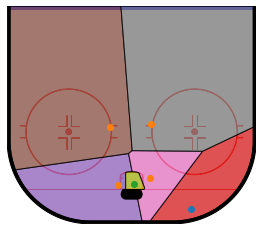

In [21]:
rink = BDCRink(rotation=270, net={"color": "black", "zorder": 90})
ax = rink.draw(display_range="ozone")

rink.scatter(*possession_coord, zorder=95)
rink.scatter(*zip(*opponent_coords))
rink.scatter(*goalie_coord, zorder=95)

for sub_polygon in sub_polygons:
    if not sub_polygon.is_empty:
        ax.fill(*rink.convert_xy(*sub_polygon.exterior.xy), alpha=0.8, edgecolor="black", zorder=19)

## Desirable Ice

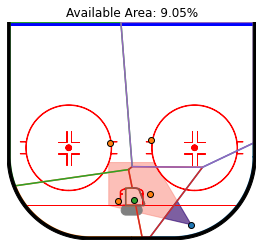

In [22]:
rink = BDCRink(rotation=270, crease={"color": "white"})
ax = rink.draw(display_range="ozone")

rink.scatter(*possession_coord, edgecolor="black")
rink.scatter(*zip(*opponent_coords), edgecolor="black")
rink.scatter(*goalie_coord, edgecolor="black")

for sub_polygon in sub_polygons:
    rink.plot(*sub_polygon.exterior.xy, ax=ax)

for sub_desirable in get_sub_polygons(desirable_ice):
    ax.fill(*rink.convert_xy(*sub_desirable.exterior.xy), color="salmon", alpha=0.5)

for sub_available in get_sub_polygons(available_ice):
    ax.fill(*rink.convert_xy(*sub_available.exterior.xy), color="darkblue", alpha=0.5)

ax.set_title(f"Available Area: {round(row.available_pct * 100, 2)}%");